## Imports

In [59]:
import math
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import time
import json

from datetime import date
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm_notebook
from xgboost import XGBRegressor

%matplotlib inline

#### Input params ##################
stk_path = "./VTI2.csv"
test_size = 0.2                # proportion of dataset to be used as test set
cv_size = 0.2                  # proportion of dataset to be used as cross-validation set
N = 3                         # for feature at day t, we use lags from t-1, t-2, ..., t-N as features

n_estimators = 100             # Number of boosted trees to fit. default = 100
max_depth = 3                  # Maximum tree depth for base learners. default = 3
learning_rate = 0.1            # Boosting learning rate (xgb’s “eta”). default = 0.1
min_child_weight = 1           # Minimum sum of instance weight(hessian) needed in a child. default = 1
subsample = 1                  # Subsample ratio of the training instance. default = 1
colsample_bytree = 1           # Subsample ratio of columns when constructing each tree. default = 1
colsample_bylevel = 1          # Subsample ratio of columns for each split, in each level. default = 1
gamma = 0                      # Minimum loss reduction required to make a further partition on a leaf node of the tree. default=0

model_seed = 100

fontsize = 14
ticklabelsize = 14
####################################

In [60]:
def get_mov_avg_std(df, col, N):
    """
    Given a dataframe, get mean and std dev at timestep t using values from t-1, t-2, ..., t-N.
    Inputs
        df         : dataframe. Can be of any length.
        col        : name of the column you want to calculate mean and std dev
        N          : get mean and std dev at timestep t using values from t-1, t-2, ..., t-N
    Outputs
        df_out     : same as df but with additional column containing mean and std dev
    """
    mean_list = df[col].rolling(window = N, min_periods=1).mean() # len(mean_list) = len(df)
    std_list = df[col].rolling(window = N, min_periods=1).std()   # first value will be NaN, because normalized by N-1
    
    # Add one timestep to the predictions
    mean_list = np.concatenate((np.array([np.nan]), np.array(mean_list[:-1])))
    std_list = np.concatenate((np.array([np.nan]), np.array(std_list[:-1])))
    
    # Append mean_list to df
    df_out = df.copy()
    df_out[col + '_mean'] = mean_list
    df_out[col + '_std'] = std_list
    
    return df_out

def scale_row(row, feat_mean, feat_std):
    """
    Given a pandas series in row, scale it to have 0 mean and var 1 using feat_mean and feat_std
    Inputs
        row      : pandas series. Need to scale this.
        feat_mean: mean  
        feat_std : standard deviation
    Outputs
        row_scaled : pandas series with same length as row, but scaled
    """
    # If feat_std = 0 (this happens if adj_close doesn't change over N days), 
    # set it to a small number to avoid division by zero
    feat_std = 0.001 if feat_std == 0 else feat_std
    
    row_scaled = (row-feat_mean) / feat_std
    
    return row_scaled

def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def train_pred_eval_model(X_train_scaled, \
                          y_train_scaled, \
                          X_test_scaled, \
                          y_test, \
                          col_mean, \
                          col_std, \
                          seed=100, \
                          n_estimators=100, \
                          max_depth=3, \
                          learning_rate=0.1, \
                          min_child_weight=1, \
                          subsample=1, \
                          colsample_bytree=1, \
                          colsample_bylevel=1, \
                          gamma=0):
    '''
    Train model, do prediction, scale back to original range and do evaluation
    Use XGBoost here.
    Inputs
        X_train_scaled     : features for training. Scaled to have mean 0 and variance 1
        y_train_scaled     : target for training. Scaled to have mean 0 and variance 1
        X_test_scaled      : features for test. Each sample is scaled to mean 0 and variance 1
        y_test             : target for test. Actual values, not scaled.
        col_mean           : means used to scale each sample of X_test_scaled. Same length as X_test_scaled and y_test
        col_std            : standard deviations used to scale each sample of X_test_scaled. Same length as X_test_scaled and y_test
        seed               : model seed
        n_estimators       : number of boosted trees to fit
        max_depth          : maximum tree depth for base learners
        learning_rate      : boosting learning rate (xgb’s “eta”)
        min_child_weight   : minimum sum of instance weight(hessian) needed in a child
        subsample          : subsample ratio of the training instance
        colsample_bytree   : subsample ratio of columns when constructing each tree
        colsample_bylevel  : subsample ratio of columns for each split, in each level
        gamma              : 
    Outputs
        rmse               : root mean square error of y_test and est
        mape               : mean absolute percentage error of y_test and est
        est                : predicted values. Same length as y_test
    '''

    model = XGBRegressor(seed=model_seed,
                         n_estimators=n_estimators,
                         max_depth=max_depth,
                         learning_rate=learning_rate,
                         min_child_weight=min_child_weight,
                         subsample=subsample,
                         colsample_bytree=colsample_bytree,
                         colsample_bylevel=colsample_bylevel,
                         gamma=gamma)
    
    # Train the model
    model.fit(X_train_scaled, y_train_scaled)
    
    # Get predicted labels and scale back to original range
    est_scaled = model.predict(X_test_scaled)
    est = est_scaled * col_std + col_mean

    # Calculate RMSE
    rmse = math.sqrt(mean_squared_error(y_test, est))
    mape = get_mape(y_test, est)
    
    return rmse, mape, est

In [61]:
datastore = json.loads(open("NIFTY.json").read())

In [62]:
date=[]
open_=[]
close_=[]
high=[]
low=[]
df1 = pd.DataFrame()
for i in datastore['history']:
    date.append(i)
    open_.append(float(datastore['history'][i]['open']))
    close_.append(float(datastore['history'][i]['close']))
    high.append(float(datastore['history'][i]['high']))
    low.append(float(datastore['history'][i]['low']))
#     temp = []
#     datastore['history'][i]['date']=i
#     df2 = pd.DataFrame(datastore['history'][i])
# #     df1.append(df2)
#     print(datastore['history'][i])
# #     for j in datastore['history'][i]:
# #         print(datastore['history'][i][j])

df = pd.DataFrame(list(zip(date, open_,close_,high,low)), 
               columns =['date', 'open','close','high','low']) 
df.loc[:, 'date'] = pd.to_datetime(df['date'],format='%Y-%m-%d')

# Change all column headings to be lower case, and remove spacing
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

# Get month of each sample
df['month'] = df['date'].dt.month

# Sort by datetime
df.sort_values(by='date', inplace=True, ascending=True)
# df = df[(df['date'].dt.year > 2002)]

df.head(10)
# print(len(date))
# print(open_)

,date,open,close,high,low,month
4868,1999-01-01,886.75,890.80,892.20,882.60,1
4867,1999-01-04,896.40,897.80,905.45,895.75,1
4866,1999-01-05,901.00,907.20,907.20,893.15,1
4865,1999-01-06,923.30,928.25,930.55,915.65,1
4864,1999-01-07,932.95,954.70,961.15,932.95,1
4863,1999-01-08,969.95,990.05,990.05,966.40,1
4862,1999-01-11,1005.15,985.60,1016.30,985.60,1
4861,1999-01-12,976.70,964.45,985.55,953.90,1
4860,1999-01-13,980.30,961.20,986.25,958.05,1
4859,1999-01-14,948.00,954.75,968.40,944.50,1


In [63]:
df['range_hl'] = df['high'] - df['low']
df.drop(['high', 'low'], axis=1, inplace=True)

# Get difference between open and close of each day
df['range_oc'] = df['open'] - df['close']
df.drop(['open'], axis=1, inplace=True)

df.head()

,date,close,month,range_hl,range_oc
4868,1999-01-01,890.80,1,9.60,-4.05
4867,1999-01-04,897.80,1,9.70,-1.40
4866,1999-01-05,907.20,1,14.05,-6.20
4865,1999-01-06,928.25,1,14.90,-4.95
4864,1999-01-07,954.70,1,28.20,-21.75


In [64]:
# Add a column 'order_day' to indicate the order of the rows by date
df['order_day'] = [x for x in list(range(len(df)))]

# merging_keys
merging_keys = ['order_day']

# List of columns that we will use to create lags
lag_cols = ['close', 'range_hl', 'range_oc']
lag_cols
df.head(10)

,date,close,month,range_hl,range_oc,order_day
4868,1999-01-01,890.80,1,9.60,-4.05,0
4867,1999-01-04,897.80,1,9.70,-1.40,1
4866,1999-01-05,907.20,1,14.05,-6.20,2
4865,1999-01-06,928.25,1,14.90,-4.95,3
4864,1999-01-07,954.70,1,28.20,-21.75,4
4863,1999-01-08,990.05,1,23.65,-20.10,5
4862,1999-01-11,985.60,1,30.70,19.55,6
4861,1999-01-12,964.45,1,31.65,12.25,7
4860,1999-01-13,961.20,1,28.20,19.10,8
4859,1999-01-14,954.75,1,23.90,-6.75,9


In [65]:
N=3
shift_range = [x+1 for x in range(N)]

for shift in tqdm_notebook(shift_range):
    train_shift = df[merging_keys + lag_cols].copy()
    
    # E.g. order_day of 0 becomes 1, for shift = 1.
    # So when this is merged with order_day of 1 in df, this will represent lag of 1.
    train_shift['order_day'] = train_shift['order_day'] + shift
    
    foo = lambda x: '{}_lag_{}'.format(x, shift) if x in lag_cols else x
    train_shift = train_shift.rename(columns=foo)

    df = pd.merge(df, train_shift, on=merging_keys, how='left') #.fillna(0)
    
del train_shift

# Remove the first N rows which contain NaNs
df = df[N:]
    
df.head(10)

,date,close,month,range_hl,range_oc,order_day,close_lag_1,range_hl_lag_1,range_oc_lag_1,close_lag_2,range_hl_lag_2,range_oc_lag_2,close_lag_3,range_hl_lag_3,range_oc_lag_3
3,1999-01-06,928.25,1,14.90,-4.95,3,907.20,14.05,-6.20,897.80,9.70,-1.40,890.80,9.60,-4.05
4,1999-01-07,954.70,1,28.20,-21.75,4,928.25,14.90,-4.95,907.20,14.05,-6.20,897.80,9.70,-1.40
5,1999-01-08,990.05,1,23.65,-20.10,5,954.70,28.20,-21.75,928.25,14.90,-4.95,907.20,14.05,-6.20
6,1999-01-11,985.60,1,30.70,19.55,6,990.05,23.65,-20.10,954.70,28.20,-21.75,928.25,14.90,-4.95
7,1999-01-12,964.45,1,31.65,12.25,7,985.60,30.70,19.55,990.05,23.65,-20.10,954.70,28.20,-21.75
8,1999-01-13,961.20,1,28.20,19.10,8,964.45,31.65,12.25,985.60,30.70,19.55,990.05,23.65,-20.10
9,1999-01-14,954.75,1,23.90,-6.75,9,961.20,28.20,19.10,964.45,31.65,12.25,985.60,30.70,19.55
10,1999-01-15,934.30,1,35.60,27.40,10,954.75,23.90,-6.75,961.20,28.20,19.10,964.45,31.65,12.25
11,1999-01-18,944.90,1,22.25,-6.25,11,934.30,35.60,27.40,954.75,23.90,-6.75,961.20,28.20,19.10
12,1999-01-19,924.10,1,24.80,20.05,12,944.90,22.25,-6.25,934.30,35.60,27.40,954.75,23.90,-6.75


In [66]:
cols_list = [
"close",
"range_hl",
"range_oc",
]

for col in cols_list:
    df = get_mov_avg_std(df, col, N)
df.head()

,date,close,month,range_hl,range_oc,order_day,close_lag_1,range_hl_lag_1,range_oc_lag_1,close_lag_2,...,range_oc_lag_2,close_lag_3,range_hl_lag_3,range_oc_lag_3,close_mean,close_std,range_hl_mean,range_hl_std,range_oc_mean,range_oc_std
3,1999-01-06,928.25,1,14.90,-4.95,3,907.20,14.05,-6.20,897.80,...,-1.40,890.80,9.60,-4.05,NaN,NaN,NaN,NaN,NaN,NaN
4,1999-01-07,954.70,1,28.20,-21.75,4,928.25,14.90,-4.95,907.20,...,-6.20,897.80,9.70,-1.40,928.250000,NaN,14.900000,NaN,-4.950000,NaN
5,1999-01-08,990.05,1,23.65,-20.10,5,954.70,28.20,-21.75,928.25,...,-4.95,907.20,14.05,-6.20,941.475000,18.702974,21.550000,9.404520,-13.350000,11.879394
6,1999-01-11,985.60,1,30.70,19.55,6,990.05,23.65,-20.10,954.70,...,-21.75,928.25,14.90,-4.95,957.666667,31.006626,22.250000,6.759623,-15.600000,9.259995
7,1999-01-12,964.45,1,31.65,12.25,7,985.60,30.70,19.55,990.05,...,-20.10,954.70,28.20,-21.75,976.783333,19.253723,27.516667,3.574330,-7.433333,23.382811


In [67]:
# Get sizes of each of the datasets
num_cv = int(cv_size*len(df))
num_test = int(test_size*len(df))
num_train = len(df) - num_cv - num_test
print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))

# Split into train, cv, and test
train = df[:num_train]
cv = df[num_train:num_train+num_cv]
train_cv = df[:num_train+num_cv]
test = df[num_train+num_cv:]
print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))

num_train = 2920
num_cv = 973
num_test = 973
train.shape = (2920, 21)
cv.shape = (973, 21)
train_cv.shape = (3893, 21)
test.shape = (973, 21)


In [68]:
cols_to_scale = [
"close"
]

for i in range(1,N+1):
    cols_to_scale.append("close_lag_"+str(i))
    cols_to_scale.append("range_hl_lag_"+str(i))
    cols_to_scale.append("range_oc_lag_"+str(i))
   
# Do scaling for train set
# Here we only scale the train dataset, and not the entire dataset to prevent information leak
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train[cols_to_scale])
print("scaler.mean_ = " + str(scaler.mean_))
print("scaler.var_ = " + str(scaler.var_))
print("train_scaled.shape = " + str(train_scaled.shape))

# Convert the numpy array back into pandas dataframe
train_scaled = pd.DataFrame(train_scaled, columns=cols_to_scale)
train_scaled[['date', 'month']] = train.reset_index()[['date', 'month']]
print("train_scaled.shape = " + str(train_scaled.shape))
train_scaled.head()

scaler.mean_ = [ 2.81219579e+03  2.81065892e+03  6.05274486e+01 -2.34342466e-01
  2.80912168e+03  6.05021062e+01 -2.58845890e-01  2.80754786e+03
  6.04763527e+01 -2.48006849e-01]
scaler.var_ = [2786538.05806013 2785494.22562268    3198.74150647    2837.1307156
 2784472.62087385    3199.44170752    2835.43402035 2783275.76266934
    3200.12619386    2835.00866226]
train_scaled.shape = (2920, 10)
train_scaled.shape = (2920, 12)


,close,close_lag_1,range_hl_lag_1,range_oc_lag_1,close_lag_2,range_hl_lag_2,range_oc_lag_2,close_lag_3,range_hl_lag_3,range_oc_lag_3,date,month
0,-1.128589,-1.140492,-0.821775,-0.112000,-1.145414,-0.898141,-0.021431,-1.148912,-0.899358,-0.071406,1999-01-06,1
1,-1.112744,-1.127880,-0.806746,-0.088532,-1.139780,-0.821237,-0.111573,-1.144716,-0.897590,-0.021636,1999-01-07,1
2,-1.091568,-1.112032,-0.571586,-0.403938,-1.127166,-0.806209,-0.088099,-1.139082,-0.820694,-0.111785,1999-01-08,1
3,-1.094233,-1.090851,-0.652036,-0.372961,-1.111315,-0.571076,-0.403599,-1.126464,-0.805668,-0.088309,1999-01-11,1
4,-1.106903,-1.093518,-0.527383,0.371434,-1.090130,-0.651516,-0.372612,-1.110610,-0.570559,-0.403833,1999-01-12,1


In [69]:
scaler_train_cv = StandardScaler()
train_cv_scaled = scaler_train_cv.fit_transform(train_cv[cols_to_scale])
print("scaler_train_cv.mean_ = " + str(scaler_train_cv.mean_))
print("scaler_train_cv.var_ = " + str(scaler_train_cv.var_))
print("train_cv_scaled.shape = " + str(train_cv_scaled.shape))

# Convert the numpy array back into pandas dataframe
train_cv_scaled = pd.DataFrame(train_cv_scaled, columns=cols_to_scale)
train_cv_scaled[['date', 'month']] = train_cv.reset_index()[['date', 'month']]
print("train_cv_scaled.shape = " + str(train_cv_scaled.shape))
train_cv_scaled.head()

scaler_train_cv.mean_ = [3.67254773e+03 3.67069318e+03 6.51529926e+01 6.78016954e-01
 3.66878528e+03 6.51277164e+01 6.98733624e-01 3.66690994e+03
 6.51041099e+01 7.13105574e-01]
scaler_train_cv.var_ = [4.66686526e+06 4.66372939e+06 3.02640861e+03 2.87486264e+03
 4.66013572e+06 3.02672407e+03 2.87310532e+03 4.65686024e+06
 3.02717571e+03 2.87216450e+03]
train_cv_scaled.shape = (3893, 10)
train_cv_scaled.shape = (3893, 12)


,close,close_lag_1,range_hl_lag_1,range_oc_lag_1,close_lag_2,range_hl_lag_2,range_oc_lag_2,close_lag_3,range_hl_lag_3,range_oc_lag_3,date,month
0,-1.270336,-1.279652,-0.928929,-0.128279,-1.283615,-1.007490,-0.039154,-1.286442,-1.008803,-0.088876,1999-01-06,1
1,-1.258092,-1.269904,-0.913478,-0.104966,-1.279261,-0.928421,-0.128704,-1.283198,-1.006985,-0.039429,1999-01-07,1
2,-1.241729,-1.257656,-0.671716,-0.418295,-1.269510,-0.912971,-0.105384,-1.278842,-0.927923,-0.128994,1999-01-08,1
3,-1.243789,-1.241287,-0.754424,-0.387521,-1.257257,-0.671222,-0.418809,-1.269087,-0.912474,-0.105670,1999-01-11,1
4,-1.253579,-1.243348,-0.626272,0.351973,-1.240882,-0.753925,-0.388026,-1.256830,-0.670743,-0.419146,1999-01-12,1


In [70]:
# Do scaling for dev set
cv_scaled = cv[['date']]
for col in tqdm_notebook(cols_list):
    feat_list = [col + '_lag_' + str(shift) for shift in range(1, N+1)]
    temp = cv.apply(lambda row: scale_row(row[feat_list], row[col+'_mean'], row[col+'_std']), axis=1)
    cv_scaled = pd.concat([cv_scaled, temp], axis=1)
    
# Now the entire dev set is scaled
cv_scaled.head()

,date,close_lag_1,close_lag_2,close_lag_3,range_hl_lag_1,range_hl_lag_2,range_hl_lag_3,range_oc_lag_1,range_oc_lag_2,range_oc_lag_3
2923,2011-05-25,-0.500789,-0.650665,1.151454,-1.154082,0.544322,0.609760,-0.325969,1.122311,-0.796343
2924,2011-05-26,-1.137958,0.738651,0.399307,-0.395931,-0.741411,1.137342,0.164350,-1.071994,0.907644
2925,2011-05-27,0.823586,-1.112706,0.289120,1.006172,-0.012460,-0.993712,-0.906695,1.072563,-0.165869
2926,2011-05-30,1.000916,-0.001835,-0.999081,1.024431,-0.050798,-0.973633,-0.775977,-0.352548,1.128525
2927,2011-05-31,0.535148,0.618548,-1.153696,-1.105973,0.840419,0.265554,1.113203,-0.822279,-0.290924


In [71]:
# Do scaling for test set
test_scaled = test[['date']]
for col in tqdm_notebook(cols_list):
    feat_list = [col + '_lag_' + str(shift) for shift in range(1, N+1)]
    temp = test.apply(lambda row: scale_row(row[feat_list], row[col+'_mean'], row[col+'_std']), axis=1)
    test_scaled = pd.concat([test_scaled, temp], axis=1)
    
# Now the entire test set is scaled
test_scaled.head()

,date,close_lag_1,close_lag_2,close_lag_3,range_hl_lag_1,range_hl_lag_2,range_hl_lag_3,range_oc_lag_1,range_oc_lag_2,range_oc_lag_3
3896,2015-05-13,-0.866271,1.094332,-0.228061,1.153043,-0.522954,-0.630088,1.151828,-0.646405,-0.505423
3897,2015-05-14,0.062775,-1.029909,0.967134,0.069928,0.963201,-1.033129,-0.484093,1.149923,-0.665830
3898,2015-05-15,0.480495,0.669062,-1.149557,-1.053766,0.118003,0.935763,-0.325501,-0.796695,1.122197
3899,2015-05-18,1.106140,-0.840020,-0.266120,-0.866275,-0.228055,1.094330,0.016625,0.991584,-1.008209
3900,2015-05-19,1.119319,-0.314010,-0.805309,0.844535,-1.104228,0.259693,-1.099512,0.244299,0.855214


In [72]:
features = []
for i in range(1,N+1):
    features.append("close_lag_"+str(i))
    features.append("range_hl_lag_"+str(i))
    features.append("range_oc_lag_"+str(i))

target = "close"


# Split into X and y
X_train = train[features]
y_train = train[target]
X_cv = cv[features]
y_cv = cv[target]
X_train_cv = train_cv[features]
y_train_cv = train_cv[target]
X_sample = test[features]
y_sample = test[target]
print("X_train.shape = " + str(X_train.shape))
print("y_train.shape = " + str(y_train.shape))
print("X_cv.shape = " + str(X_cv.shape))
print("y_cv.shape = " + str(y_cv.shape))
print("X_train_cv.shape = " + str(X_train_cv.shape))
print("y_train_cv.shape = " + str(y_train_cv.shape))
print("X_sample.shape = " + str(X_sample.shape))
print("y_sample.shape = " + str(y_sample.shape))

X_train.shape = (2920, 9)
y_train.shape = (2920,)
X_cv.shape = (973, 9)
y_cv.shape = (973,)
X_train_cv.shape = (3893, 9)
y_train_cv.shape = (3893,)
X_sample.shape = (973, 9)
y_sample.shape = (973,)


In [73]:
# Split into X and y
X_train_scaled = train_scaled[features]
y_train_scaled = train_scaled[target]
X_cv_scaled = cv_scaled[features]
X_train_cv_scaled = train_cv_scaled[features]
y_train_cv_scaled = train_cv_scaled[target]
X_sample_scaled = test_scaled[features]
print("X_train_scaled.shape = " + str(X_train_scaled.shape))
print("y_train_scaled.shape = " + str(y_train_scaled.shape))
print("X_cv_scaled.shape = " + str(X_cv_scaled.shape))
print("X_train_cv_scaled.shape = " + str(X_train_cv_scaled.shape))
print("y_train_cv_scaled.shape = " + str(y_train_cv_scaled.shape))
print("X_sample_scaled.shape = " + str(X_sample_scaled.shape))

X_train_scaled.shape = (2920, 9)
y_train_scaled.shape = (2920,)
X_cv_scaled.shape = (973, 9)
X_train_cv_scaled.shape = (3893, 9)
y_train_cv_scaled.shape = (3893,)
X_sample_scaled.shape = (973, 9)


In [74]:
# Create the model
model = XGBRegressor(seed=model_seed,
                     n_estimators=n_estimators,
                     max_depth=max_depth,
                     learning_rate=learning_rate,
                     min_child_weight=min_child_weight,
                     subsample=subsample,
                     colsample_bytree=colsample_bytree,
                     colsample_bylevel=colsample_bylevel,
                     gamma=gamma)

# Train the regressor
model.fit(X_train_scaled, y_train_scaled)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=100, silent=True,
       subsample=1)

In [76]:
# Do prediction on train set
est_scaled = model.predict(X_train_scaled)
est = est_scaled * math.sqrt(scaler.var_[0]) + scaler.mean_[0]

# Calculate RMSE
print("RMSE on train set = %0.3f" % math.sqrt(mean_squared_error(y_train, est)))

# Calculate MAPE
print("MAPE on train set = %0.3f%%" % get_mape(y_train, est))

RMSE on train set = 44.808
MAPE on train set = 1.087%


Text(0.5, 1.0, 'Training Dataset')

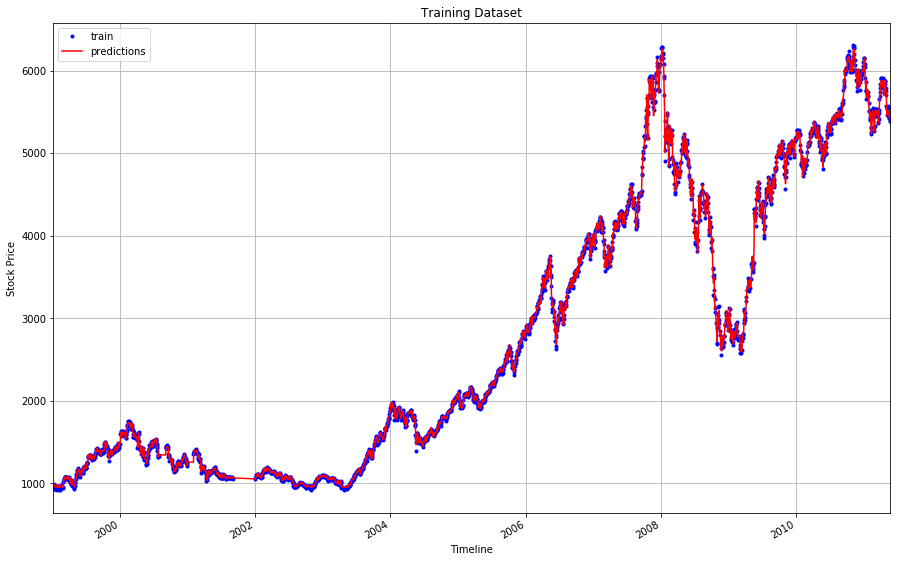

In [77]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 15, 10 # width 10, height 8

est_df = pd.DataFrame({'est': est, 
                       'date': train['date']})

ax = train.plot(x='date', y='close', style='b.', grid=True)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'predictions'])
# ax.set_xlim([date(2002, 8, 1), date(2010, 5, 31)])
ax.set_xlabel("Timeline")
ax.set_ylabel("Stock Price")
ax.set_title('Training Dataset')

In [78]:
# Do prediction on test set
est_scaled = model.predict(X_cv_scaled)
cv['est_scaled'] = est_scaled
cv['est'] = cv['est_scaled'] * cv['close_std'] + cv['close_mean']

# Calculate RMSE
rmse_bef_tuning = math.sqrt(mean_squared_error(y_cv, cv['est']))
print("RMSE on dev set = %0.3f" % rmse_bef_tuning)

# Calculate MAPE
mape_bef_tuning = get_mape(y_cv, cv['est'])
print("MAPE on dev set = %0.3f%%" % mape_bef_tuning)

RMSE on dev set = 64.842
MAPE on dev set = 0.813%


/home/aniket/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/aniket/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


Text(0.5, 1.0, 'Validation Dataset')

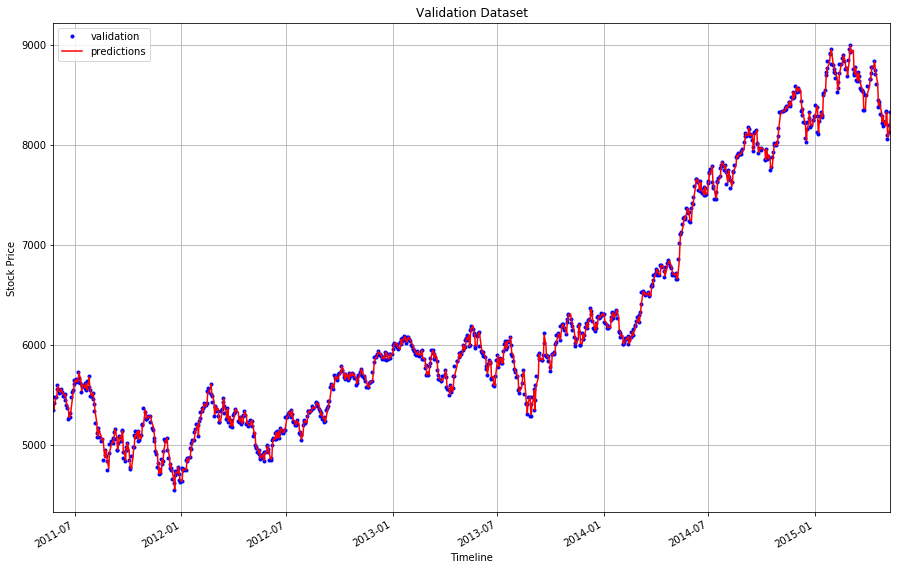

In [79]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 15, 10 # width 10, height 8

est_df = pd.DataFrame({'est': cv['est'], 
                       'y_cv': y_cv,
                       'date': cv['date']})

# ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='close', style='b.', grid=True)
# ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['validation', 'predictions'])
ax.set_xlabel("Timeline")
ax.set_ylabel("Stock Price")
ax.set_title("Validation Dataset")

In [80]:
param_label = 'n_estimators'
param_list = range(10, 310, 10)

param2_label = 'max_depth'
param2_list = [2, 3, 4, 5, 6, 7, 8, 9]

error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
#     print("param = " + str(param))
    
    for param2 in param2_list:
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_cv_scaled, 
                                     y_cv, 
                                     cv['close_mean'],
                                     cv['close_std'],
                                     seed=model_seed,
                                     n_estimators=param, 
                                     max_depth=param2, 
                                     learning_rate=learning_rate, 
                                     min_child_weight=min_child_weight, 
                                     subsample=subsample, 
                                     colsample_bytree=colsample_bytree, 
                                     colsample_bylevel=colsample_bylevel, 
                                     gamma=gamma)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate   

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6


Minutes taken = 2.3802048683166506


,n_estimators,max_depth,rmse,mape_pct
0,10,2,68.268351,0.868124
1,10,3,67.940623,0.864359
2,10,4,67.894931,0.863497
3,10,5,67.882753,0.863315
4,10,6,67.900968,0.863605
5,10,7,67.910913,0.863770
6,10,8,67.918940,0.863959
7,10,9,67.918156,0.864079
8,20,2,65.186682,0.816808
9,20,3,65.177070,0.817896


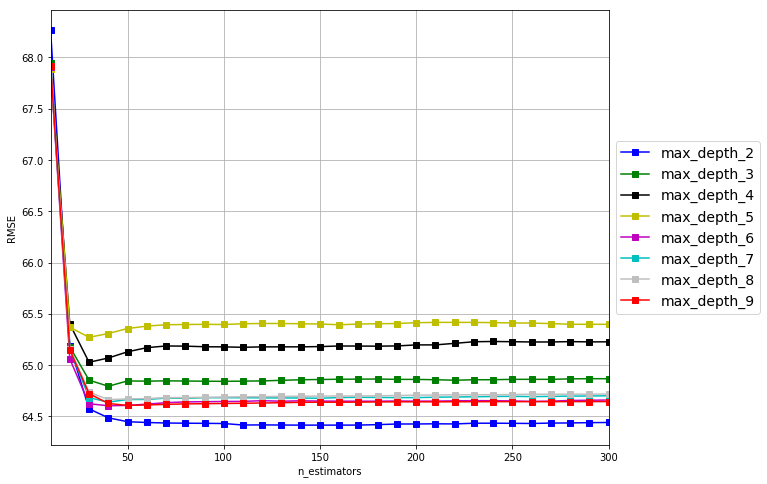

In [81]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [82]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
n_estimators_opt = temp['n_estimators'].values[0]
max_depth_opt = temp['max_depth'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
n_estimators_opt, max_depth_opt

min RMSE = 64.415
optimum params = 


(160, 2)

In [83]:
# Get optimum value for param and param2, using MAPE
temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum params = ")
temp['n_estimators'].values[0], temp['max_depth'].values[0]

min MAPE = 0.801%
optimum params = 


(140, 2)

In [85]:
param_label = 'learning_rate'
param_list = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3]

param2_label = 'min_child_weight'
param2_list = range(5, 21, 1)

error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
#     print("param = " + str(param))
    
    for param2 in param2_list:
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_cv_scaled, 
                                     y_cv, 
                                     cv['close_mean'],
                                     cv['close_std'],
                                     seed=model_seed,
                                     n_estimators=n_estimators_opt, 
                                     max_depth=max_depth_opt, 
                                     learning_rate=param, 
                                     min_child_weight=param2, 
                                     subsample=subsample, 
                                     colsample_bytree=colsample_bytree, 
                                     colsample_bylevel=colsample_bylevel, 
                                     gamma=gamma)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate   

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6


Minutes taken = 0.4156382083892822


,learning_rate,min_child_weight,rmse,mape_pct
0,0.001,5,81.026208,1.041741
1,0.001,6,81.026208,1.041741
2,0.001,7,81.026208,1.041741
3,0.001,8,81.026208,1.041741
4,0.001,9,81.026208,1.041741
5,0.001,10,81.026208,1.041741
6,0.001,11,81.026208,1.041741
7,0.001,12,81.026208,1.041741
8,0.001,13,81.026208,1.041741
9,0.001,14,81.026208,1.041741


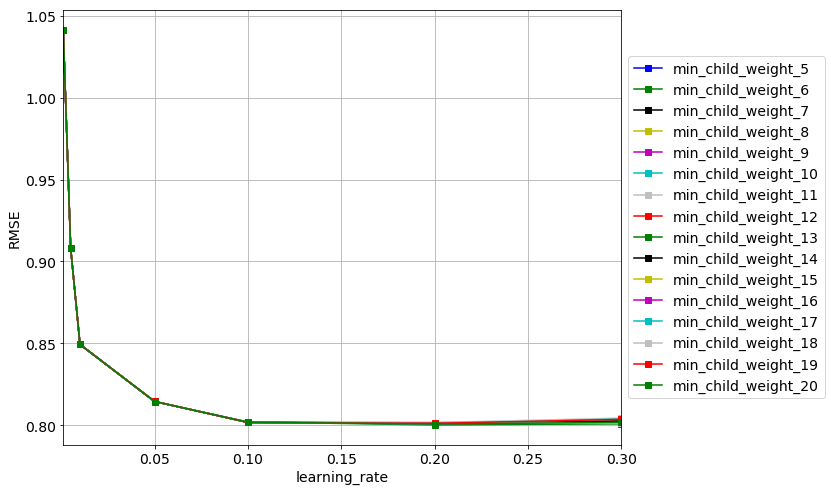

In [87]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='mape_pct', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='mape_pct', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [88]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
learning_rate_opt = temp['learning_rate'].values[0]
min_child_weight_opt = temp['min_child_weight'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
learning_rate_opt, min_child_weight_opt

min RMSE = 64.425
optimum params = 


(0.1, 5)

In [89]:
# Get optimum value for param and param2, using MAPE
# We will use RMSE to decide the final optimum params to use
temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum params = ")
temp['learning_rate'].values[0], temp['min_child_weight'].values[0]

min MAPE = 0.800%
optimum params = 


(0.2, 6)

In [91]:
param_label = 'subsample'
param_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

param2_label = 'gamma'
param2_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
#     print("param = " + str(param))
    
    for param2 in param2_list:
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_cv_scaled, 
                                     y_cv, 
                                     cv['close_mean'],
                                     cv['close_std'],
                                     seed=model_seed,
                                     n_estimators=n_estimators_opt, 
                                     max_depth=max_depth_opt, 
                                     learning_rate=learning_rate_opt, 
                                     min_child_weight=min_child_weight_opt, 
                                     subsample=param, 
                                     colsample_bytree=colsample_bytree, 
                                     colsample_bylevel=colsample_bylevel, 
                                     gamma=param2)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate   

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6


Minutes taken = 0.3338829199473063


,subsample,gamma,rmse,mape_pct
0,0.1,0.1,66.910278,0.848757
1,0.1,0.2,67.046166,0.851538
2,0.1,0.3,66.987638,0.850495
3,0.1,0.4,67.129446,0.852764
4,0.1,0.5,67.287097,0.855356
5,0.1,0.6,67.376738,0.856838
6,0.1,0.7,67.424304,0.857566
7,0.1,0.8,67.657381,0.861199
8,0.1,0.9,67.634389,0.861061
9,0.1,1.0,67.392639,0.856956


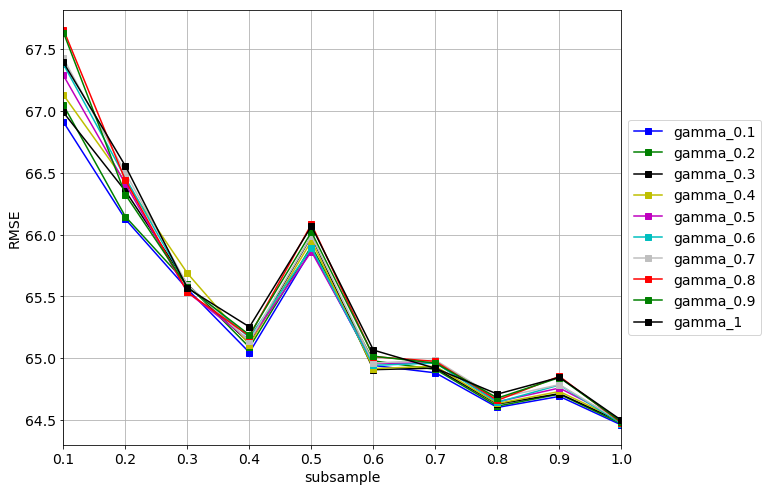

In [92]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [93]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
subsample_opt = temp['subsample'].values[0]
gamma_opt = temp['gamma'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
subsample_opt, gamma_opt

min RMSE = 64.459
optimum params = 


(1.0, 0.1)

In [94]:
# Get optimum value for param and param2, using MAPE
# We will use RMSE to decide the final optimum params to use
temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum params = ")
temp['subsample'].values[0], temp['gamma'].values[0]

min MAPE = 0.802%
optimum params = 


(1.0, 0.8)

In [96]:
param_label = 'colsample_bytree'
param_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

param2_label = 'colsample_bylevel'
param2_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
#     print("param = " + str(param))
    
    for param2 in param2_list:
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_cv_scaled, 
                                     y_cv, 
                                     cv['close_mean'],
                                     cv['close_std'],
                                     seed=model_seed,
                                     n_estimators=n_estimators_opt, 
                                     max_depth=max_depth_opt, 
                                     learning_rate=learning_rate_opt, 
                                     min_child_weight=min_child_weight_opt, 
                                     subsample=subsample_opt, 
                                     colsample_bytree=param, 
                                     colsample_bylevel=param2, 
                                     gamma=gamma_opt)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate   

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6


Minutes taken = 0.10170884529749552


,colsample_bytree,colsample_bylevel,rmse,mape_pct
0,0.5,0.5,79.028129,1.027472
1,0.5,0.6,79.028129,1.027472
2,0.5,0.7,79.028129,1.027472
3,0.5,0.8,79.079874,1.027565
4,0.5,0.9,79.079874,1.027565
5,0.5,1.0,81.065065,1.055992
6,0.6,0.5,75.207668,0.971900
7,0.6,0.6,78.389206,1.014015
8,0.6,0.7,78.389206,1.014015
9,0.6,0.8,76.085323,0.980515


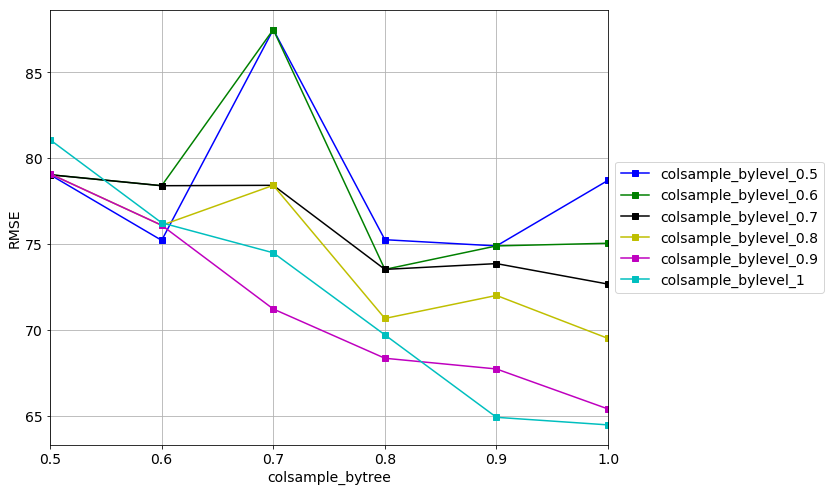

In [97]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [98]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
colsample_bytree_opt = temp['colsample_bytree'].values[0]
colsample_bylevel_opt = temp['colsample_bylevel'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
colsample_bytree_opt, colsample_bylevel_opt

min RMSE = 64.459
optimum params = 


(1.0, 1.0)

In [99]:
# Get optimum value for param and param2, using MAPE
# We will use RMSE to decide the final optimum params to use
temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum params = ")
temp['colsample_bytree'].values[0], temp['colsample_bylevel'].values[0]

min MAPE = 0.802%
optimum params = 


(1.0, 1.0)

In [100]:
d = {'param': ['n_estimators', 'max_depth', 'learning_rate', 'min_child_weight', 'subsample', 'colsample_bytree', 'colsample_bylevel', 'gamma', 'rmse', 'mape_pct'],
     'original': [n_estimators, max_depth, learning_rate, min_child_weight, subsample, colsample_bytree, colsample_bylevel, gamma, rmse_bef_tuning, mape_bef_tuning],
     'after_tuning': [n_estimators_opt, max_depth_opt, learning_rate_opt, min_child_weight_opt, subsample_opt, colsample_bytree_opt, colsample_bylevel_opt, gamma_opt, error_rate['rmse'].min(), error_rate['mape_pct'].min()]}
tuned_params = pd.DataFrame(d)
tuned_params = tuned_params.round(3)
tuned_params

,param,original,after_tuning
0,n_estimators,100.000,160.000
1,max_depth,3.000,2.000
2,learning_rate,0.100,0.100
3,min_child_weight,1.000,5.000
4,subsample,1.000,1.000
5,colsample_bytree,1.000,1.000
6,colsample_bylevel,1.000,1.000
7,gamma,0.000,0.100
8,rmse,64.842,64.459
9,mape_pct,0.813,0.802


In [101]:
rmse, mape, est = train_pred_eval_model(X_train_cv_scaled, 
                             y_train_cv_scaled, 
                             X_sample_scaled, 
                             y_sample, 
                             test['close_mean'],
                             test['close_std'],
                             seed=model_seed,
                             n_estimators=n_estimators_opt, 
                             max_depth=max_depth_opt, 
                             learning_rate=learning_rate_opt, 
                             min_child_weight=min_child_weight_opt, 
                             subsample=subsample_opt, 
                             colsample_bytree=colsample_bytree_opt, 
                             colsample_bylevel=colsample_bylevel_opt, 
                             gamma=gamma_opt)

# Calculate RMSE
print("RMSE on test set = %0.3f" % rmse)

# Calculate MAPE
print("MAPE on test set = %0.3f%%" % mape)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


RMSE on test set = 74.705
MAPE on test set = 0.613%


Text(0.5, 1.0, 'Testing Performance')

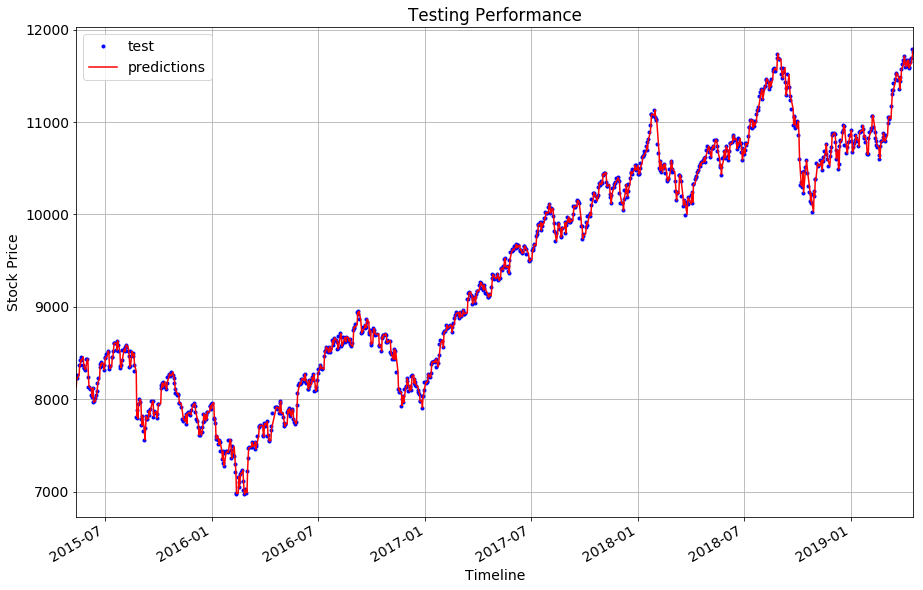

In [103]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 15, 10 # width 10, height 8

est_df = pd.DataFrame({'est': est, 
                       'y_sample': y_sample,
                       'date': test['date']})

# ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
# ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='close', style='b.', grid=True)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['test', 'predictions'])
# ax.set_xlim([date(2015, 9, 14), date(2019, 4, 2)])
ax.set_xlabel("Timeline")
ax.set_ylabel("Stock Price")
ax.set_title("Testing Performance")
# est_df.tail()
